In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from utils.docking import cal_docking
from utils.metric import *
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from rdkit.Chem.Descriptors import qed
from utils.sascorer import compute_sa_score
from utils.misc import *
import matplotlib.pyplot as plt
from tabulate import tabulate

In [17]:
# Load configs
config = load_config('./configs/rl.yml')
seed_all(config.sample.seed)

## Cal metrics

In [18]:
def cal_high_affinity(results_path, top_num, sort_metric, test_path='./baselines_results/org_sdf_files/testset/'):
    high_affinity_result = []
    mpbg_list = []
    for test_name in os.listdir(test_path):
        for results_name in os.listdir(results_path):
            if test_name.split('-')[0] == results_name.split('-')[0]:
                test_value = pd.read_csv(test_path + test_name)['Qvina'].mean()
                results_value = pd.read_csv(results_path + results_name).head(100)
                
                if sort_metric == 'Qvina':
                    results_value.sort_values(by=sort_metric, inplace=True, ascending=True)
                else:
                    results_value.sort_values(by=sort_metric, inplace=True, ascending=False)  
                # results_value.sort_values(by=sort_metric, inplace=True)
           
                # cal MPBG
                min_test_value = pd.read_csv(test_path + test_name)['Qvina'].mean()
                sum_mpbg = 0
                lenth = 0
         
                for qvina in results_value.head(top_num)['Qvina'].values:
                    if not np.isnan(qvina):
                        sum_mpbg += ((min_test_value - qvina) / min_test_value)
                        lenth += 1

                if lenth:
                    mpbg_list.append(sum_mpbg / lenth)
                else:
                    mpbg_list.append(0)
                    
                results_value = results_value.head(top_num)
                high_affinity = (results_value['Qvina'] < test_value).sum()
                high_affinity_result.append((high_affinity / top_num))
   
    return np.mean(high_affinity_result), np.mean(mpbg_list)

def read_and_process_file(file_path, sort_metric):
    """
    Reads a CSV file, processes it, and returns a DataFrame.
    """
    df = pd.read_csv(file_path, nrows=100)
    df.iloc[:, ~df.columns.isin(['SMILES'])] = df.iloc[:, ~df.columns.isin(['SMILES'])].apply(pd.to_numeric, errors='coerce')
    if sort_metric == 'Qvina':
        df.sort_values(by=sort_metric, inplace=True, ascending=True)
    else:
        df.sort_values(by=sort_metric, inplace=True, ascending=False)
    return df

def get_top_n_dfs(df, top_n_list):
    """
    Returns a dictionary of DataFrames for each specified top N.
    """
    return {n: df.head(n) for n in top_n_list}

def calculate_statistics(path, top_dfs, top_nums, sort_metric):
    """
    Calculates statistics for given top N DataFrames, adds a title, and prints them in a table format with top N as rows.
    """
    all_stats = []
    for top_num in top_nums:
        top_df = top_dfs[top_num]
        top_mean = top_df.mean().round(3)
        top_std = top_df.std().round(2)

        high_affinity_mean, mpbg_mean = cal_high_affinity(path, top_num, sort_metric)

        stats = {
            'Top': f'Top {top_num}',
            'Qvina': f"{top_mean['Qvina']} ± {top_std['Qvina']}",
            'HA': f"{high_affinity_mean.round(3)}",
            'MPBG': f"{mpbg_mean.round(2)}",
            'QED': f"{top_mean['QED']} ± {top_std['QED']}",
            'SA': f"{top_mean['SA']} ± {top_std['SA']}",
            'Lipinski': f"{top_mean['Lip']} ± {top_std['Lip']}",  
        }

        all_stats.append(stats)

    stats_df = pd.DataFrame(all_stats).set_index('Top')
    print(tabulate(stats_df, headers='keys', tablefmt='pretty', showindex=True))
    
def cal_result(path, sort_metric, show_result=False, return_df=False):
    top_n_list = [1, 3, 5, 10]
    top_dfs = {n: [] for n in top_n_list}
    
    result_files = [file_name for file_name in os.listdir(path) if file_name.endswith('.csv')]
    
    for file_name in result_files:
        df = read_and_process_file(os.path.join(path, file_name), sort_metric)
        for n, top_df in get_top_n_dfs(df, top_n_list).items():
            top_dfs[n].append(top_df)
            
    # Concatenate all top N DataFrames
    
    top_dfs = {n: pd.concat(dfs) for n, dfs in top_dfs.items()}
    if return_df:
        return top_dfs
    if show_result:
        calculate_statistics(path, top_dfs, top_n_list, sort_metric)
    
    



In [19]:
sort_metric = 'Qvina' # Qvina QED SA 

## Ours

In [20]:

results_path = 'baselines_results/eval_files/AMG/'
cal_result(results_path, sort_metric, show_result=True)  
# results_path = 'results/ablation/1_woRL_66k_results/'
# cal_result(results_path, sort_metric='Qvina') 
# results_path = 'results/ablation/wo_PR_results/'
# cal_result(results_path, sort_metric='Qvina') 

+--------+----------------+-------+-------+--------------+--------------+--------------+
|  Top   |     Qvina      |  HA   | MPBG  |     QED      |      SA      |   Lipinski   |
+--------+----------------+-------+-------+--------------+--------------+--------------+
| Top 1  | -10.201 ± 1.62 | 0.98  | -1.52 | 0.524 ± 0.15 | 0.514 ± 0.1  | 4.82 ± 0.39  |
| Top 3  | -9.765 ± 1.51  | 0.973 | -1.43 | 0.538 ± 0.15 | 0.514 ± 0.11 | 4.893 ± 0.31 |
| Top 5  | -9.508 ± 1.47  | 0.958 | -1.37 | 0.553 ± 0.15 | 0.512 ± 0.1  | 4.91 ± 0.29  |
| Top 10 | -9.102 ± 1.42  | 0.928 | -1.27 | 0.56 ± 0.14  | 0.515 ± 0.11 | 4.932 ± 0.25 |
+--------+----------------+-------+-------+--------------+--------------+--------------+


## FLAG

In [21]:
results_path = 'baselines_results/eval_files/FLAG/'
cal_result(results_path, sort_metric, show_result=True) 

+--------+---------------+-------+-------+--------------+--------------+--------------+
|  Top   |     Qvina     |  HA   | MPBG  |     QED      |      SA      |   Lipinski   |
+--------+---------------+-------+-------+--------------+--------------+--------------+
| Top 1  | -9.837 ± 1.6  | 0.96  | -1.45 | 0.436 ± 0.17 | 0.397 ± 0.13 | 4.28 ± 0.94  |
| Top 3  | -9.414 ± 1.48 | 0.93  | -1.34 | 0.458 ± 0.17 | 0.406 ± 0.12 | 4.377 ± 0.83 |
| Top 5  | -9.159 ± 1.42 | 0.908 | -1.29 | 0.468 ± 0.16 | 0.406 ± 0.12 | 4.432 ± 0.81 |
| Top 10 | -8.756 ± 1.37 | 0.873 | -1.19 | 0.476 ± 0.16 | 0.415 ± 0.12 | 4.493 ± 0.76 |
+--------+---------------+-------+-------+--------------+--------------+--------------+


## ResGen

In [22]:
results_path = 'baselines_results/eval_files/ResGen/'
cal_result(results_path, sort_metric, show_result=True) 

+--------+---------------+-------+-------+--------------+--------------+--------------+
|  Top   |     Qvina     |  HA   | MPBG  |     QED      |      SA      |   Lipinski   |
+--------+---------------+-------+-------+--------------+--------------+--------------+
| Top 1  | -8.693 ± 2.3  | 0.91  | -0.96 | 0.567 ± 0.15 | 0.796 ± 0.12 | 4.94 ± 0.28  |
| Top 3  | -8.429 ± 2.25 | 0.883 | -0.89 | 0.566 ± 0.16 | 0.804 ± 0.12 | 4.913 ± 0.33 |
| Top 5  | -8.292 ± 2.21 | 0.856 | -0.85 | 0.571 ± 0.16 | 0.802 ± 0.11 | 4.912 ± 0.34 |
| Top 10 | -8.083 ± 2.16 | 0.824 | -0.8  | 0.579 ± 0.16 |  0.8 ± 0.11  | 4.908 ± 0.34 |
+--------+---------------+-------+-------+--------------+--------------+--------------+


## DecompDiff

In [23]:
results_path = 'baselines_results/eval_files/DecompDiff/'
cal_result(results_path, sort_metric, show_result=True) 

## TargetDiff

In [ ]:
results_path = 'baselines_results/eval_files/TargetDiff/'
cal_result(results_path, sort_metric, show_result=True) 

+--------+---------------+-------+-------+--------------+--------------+--------------+
|  Top   |     Qvina     |  HA   | MPBG  |     QED      |      SA      |   Lipinski   |
+--------+---------------+-------+-------+--------------+--------------+--------------+
| Top 1  | -9.278 ± 1.75 | 0.94  | -1.22 | 0.426 ± 0.2  | 0.476 ± 0.12 | 4.42 ± 0.82  |
| Top 3  | -8.892 ± 1.68 | 0.923 | -1.12 | 0.457 ± 0.21 | 0.502 ± 0.12 | 4.453 ± 0.88 |
| Top 5  | -8.686 ± 1.65 | 0.908 | -1.07 | 0.453 ± 0.21 | 0.511 ± 0.12 | 4.446 ± 0.87 |
| Top 10 | -8.37 ± 1.61  | 0.885 | -1.0  | 0.466 ± 0.2  | 0.523 ± 0.12 | 4.519 ± 0.79 |
+--------+---------------+-------+-------+--------------+--------------+--------------+


## Pocket2Mol

In [ ]:
results_path = 'baselines_results/eval_files/Pocket2Mol/'
cal_result(results_path, sort_metric, show_result=True) 

+--------+---------------+-------+-------+--------------+--------------+--------------+
|  Top   |     Qvina     |  HA   | MPBG  |     QED      |      SA      |   Lipinski   |
+--------+---------------+-------+-------+--------------+--------------+--------------+
| Top 1  | -8.785 ± 2.88 | 0.88  | -0.95 | 0.517 ± 0.14 | 0.778 ± 0.13 | 4.95 ± 0.22  |
| Top 3  | -8.525 ± 2.9  | 0.827 | -0.86 | 0.525 ± 0.15 | 0.777 ± 0.12 | 4.947 ± 0.24 |
| Top 5  | -8.395 ± 2.88 | 0.804 | -0.81 | 0.528 ± 0.15 | 0.781 ± 0.12 | 4.946 ± 0.24 |
| Top 10 | -8.19 ± 2.83  | 0.771 | -0.76 | 0.53 ± 0.15  | 0.78 ± 0.12  | 4.941 ± 0.28 |
+--------+---------------+-------+-------+--------------+--------------+--------------+


## Ablation study

In [ ]:
import pandas as pd
import numpy as np
from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools
from rdkit.Chem.QED import qed
from rdkit.Chem import QED, rdMolDescriptors
from rdkit.Chem import FilterCatalog
from rdkit.Chem.Draw import IPythonConsole
import os
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import laplace
import warnings
warnings.filterwarnings('ignore')
import torch
from matplotlib.ticker import FuncFormatter


In [ ]:
num = 5
wo_IA_df = cal_result('results/ablation/1_woRL_66k_results/', sort_metric, return_df=True)[num]
wo_PR_IA_df = cal_result('results/ablation/3_wo_RL&PR_results/', sort_metric, return_df=True)[num]
wo_PR_df = cal_result('results/ablation/wo_PR_results/', sort_metric, return_df=True)[num] 
flag_df = cal_result('baselines_results/eval_files/FLAG/', sort_metric, return_df=True)[num] 
ours_df = cal_result('baselines_results/eval_files/AMG/', sort_metric, return_df=True)[num] 


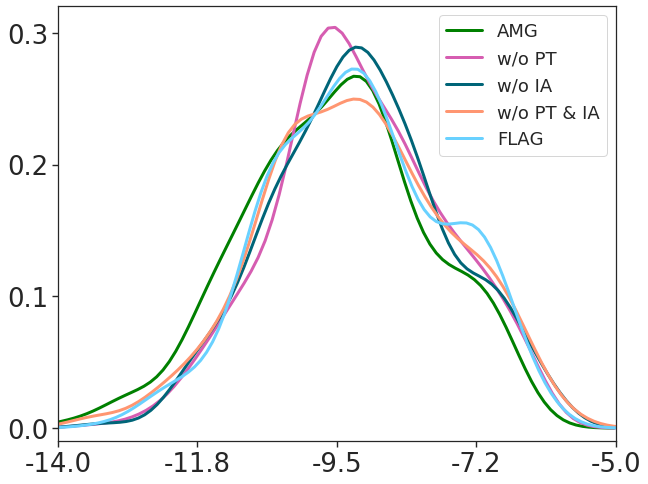

In [ ]:
# Qvina
sns.set_palette("hls")
sns.set_style("ticks", {"axes.facecolor": "white"})
fig = plt.figure(figsize=(10, 8))
sns.distplot(ours_df['Qvina'], hist=False, label='AMG', color='green', kde=True, kde_kws={'linewidth': 3})
sns.distplot(wo_PR_df['Qvina'], hist=False, label='w/o PT', color='#D65DB1', kde=True, kde_kws={'linewidth': 3})
# sns.distplot(wo_IA_df['Qvina'], hist=False, label='w/o IA', color='#006578', kde=True, kde_kws={'linewidth': 3})
sns.distplot(wo_PR_IA_df['Qvina'], hist=False, label='w/o PT & IA', color='#FF9671',  kde=True, kde_kws={'linewidth': 3})
sns.distplot(flag_df['Qvina'], hist=False, label='FLAG', color='#69D1FF',  kde=True, kde_kws={'linewidth': 3})

plt.xlabel('', fontsize=26)
plt.ylabel('',  fontsize=26)

plt.xticks(np.linspace(-14, -5, 5), fontsize=26)
plt.yticks(np.linspace(0, 0.3, 4), fontsize=26)

def format_func_x(value, tick_number):
    return f'{value:.1f}'  
def format_func_y(value, tick_number):
    return f'{value:.1f}' 
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func_x)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func_y)) 


plt.gca().tick_params(axis='x', direction='out', length=6, width=1.4)  # x 轴
plt.gca().tick_params(axis='y', direction='out', length=6, width=1.4)  # y 轴

plt.xlim(-14, -5)
plt.ylim(-0.01, 0.32)

plt.legend(fontsize=18, loc='upper right', frameon=True)     #   upper right
plt.savefig(fname='evaluation/images/' + str(num) + '_ablation_Qvina.png')
plt.savefig(fname='evaluation/images/' + str(num) + '_ablation_Qvina.svg')
plt.show(block=True)

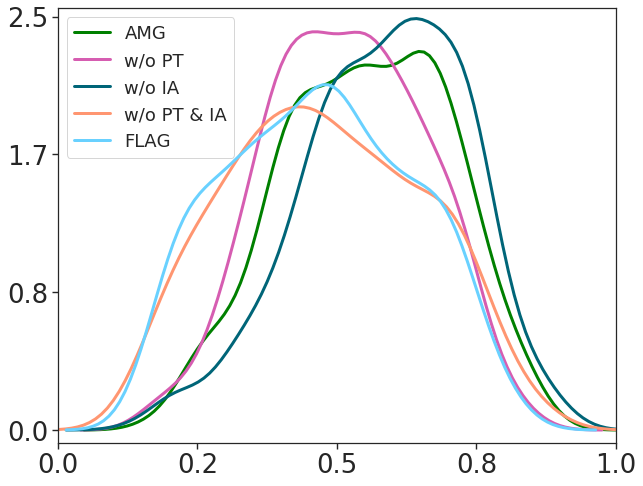

In [ ]:

# QED
sns.set_palette("hls")
sns.set_style("ticks", {"axes.facecolor": "white"})
fig = plt.figure(figsize=(10, 8))
sns.distplot(ours_df['QED'], hist=False, label='AMG', color='green', kde=True, kde_kws={'linewidth': 3})
sns.distplot(wo_PR_df['QED'], hist=False, label='w/o PT', color='#D65DB1', kde=True, kde_kws={'linewidth': 3})
# sns.distplot(wo_IA_df['QED'], hist=False, label='w/o IA', color='#006578', kde=True, kde_kws={'linewidth': 3})
sns.distplot(wo_PR_IA_df['QED'], hist=False, label='w/o PT & IA', color='#FF9671',  kde=True, kde_kws={'linewidth': 3})
sns.distplot(flag_df['QED'], hist=False, label='FLAG', color='#69D1FF',  kde=True, kde_kws={'linewidth': 3})

plt.xlabel('', fontsize=26)
plt.ylabel('',  fontsize=26)

plt.xticks(np.linspace(0, 1, 5), fontsize=26)
plt.yticks(np.linspace(0, 2.5, 4), fontsize=26)


def format_func_x(value, tick_number):
    return f'{value:.1f}' 
def format_func_y(value, tick_number):
    return f'{value:.1f}' 
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func_x)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func_y)) 


plt.gca().tick_params(axis='x', direction='out', length=6, width=1.4)
plt.gca().tick_params(axis='y', direction='out', length=6, width=1.4) 


plt.xlim(0, 1)
plt.ylim(-0.08, 2.55)

plt.legend(fontsize=18, loc='upper left', frameon=True)
plt.savefig(fname='evaluation/images/' + str(num) + '_ablation_QED.png')
plt.savefig(fname='evaluation/images/' + str(num) + '_ablation_QED.svg')
plt.show(block=True)


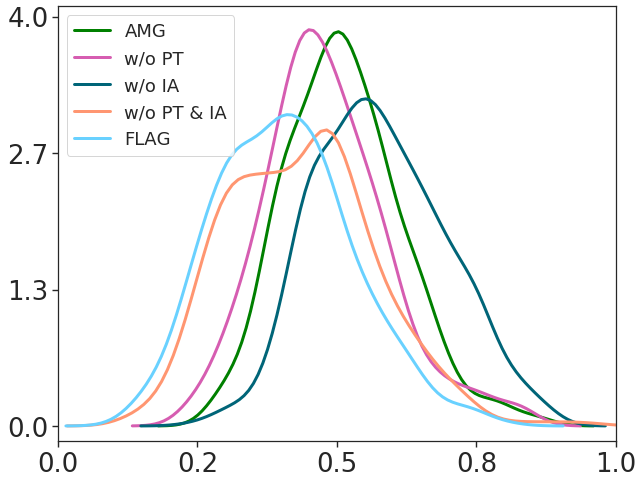

In [ ]:
# SA
sns.set_palette("hls")
sns.set_style("ticks", {"axes.facecolor": "white"})
fig = plt.figure(figsize=(10, 8))
sns.distplot(ours_df['SA'], hist=False, label='AMG', color='green', kde=True, kde_kws={'linewidth': 3})
sns.distplot(wo_PR_df['SA'], hist=False, label='w/o PT', color='#D65DB1', kde=True, kde_kws={'linewidth': 3})
# sns.distplot(wo_IA_df['SA'], hist=False, label='w/o IA', color='#006578', kde=True, kde_kws={'linewidth': 3})
sns.distplot(wo_PR_IA_df['SA'], hist=False, label='w/o PT & IA', color='#FF9671',  kde=True, kde_kws={'linewidth': 3})
sns.distplot(flag_df['SA'], hist=False, label='FLAG', color='#69D1FF',  kde=True, kde_kws={'linewidth': 3})

plt.xlabel('', fontsize=26)
plt.ylabel('',  fontsize=26)

plt.xticks(np.linspace(0, 1, 5), fontsize=26)
plt.yticks(np.linspace(0, 4, 4), fontsize=26)

def format_func_x(value, tick_number):
    return f'{value:.1f}' 
def format_func_y(value, tick_number):
    return f'{value:.1f}' 
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func_x)) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func_y)) 
    

plt.gca().tick_params(axis='x', direction='out', length=6, width=1.4)  
plt.gca().tick_params(axis='y', direction='out', length=6, width=1.4)  

plt.xlim(0, 1)
plt.ylim(-0.15, 4.1)

plt.legend(fontsize=18, loc='upper left', frameon=True)
plt.savefig(fname='evaluation/images/' + str(num) + '_ablation_SA.png')
plt.savefig(fname='evaluation/images/' + str(num) + '_ablation_SA.svg')
plt.show(block=True)